<h1 style="text-align:center; font-size:40px;">Search Relevance Prediction Project</h1>
<h2 style="text-align:center; font-size:20px;">Enhancing Home Depot’s Customer Experience</h2>

In [1]:
! pip install -U neptune-client sentence-transformers lightning --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.11.2 requires botocore<1.34.35,>=1.33.2, but you have botocore 1.34.98 which is incompatible.


In [69]:
import neptune
from neptune import Project
from pytorch_lightning.loggers import NeptuneLogger
import pytorch_lightning as L
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, ModelSummary, EarlyStopping
import torch.optim as optim
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBRegressor
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import transforms
import torchmetrics
import matplotlib.pyplot as plt
import seaborn as sns
import time
import nltk
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore", category=FutureWarning)

os.environ["TOKENIZERS_PARALLELISM"] = "false"
sns.set(style='whitegrid')

In [3]:
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "logs")
# Function for setting the seed
L.seed_everything(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

In [5]:
def plot_hist(df, col_name, title, x_title):
    """
    Plots a histogram with kernel density estimate (KDE) for a given column in a DataFrame.

    Parameters:
    - df (DataFrame): The DataFrame containing the data.
    - col_name (str): The name of the column for which the histogram is to be plotted.
    - title (str): The title of the plot.
    - x_title (str): The label for the x-axis.

    Returns:
    - None
    """
    plt.figure(figsize=(6, 4))
    ax = sns.histplot(df[col_name], bins=20, kde=True, color='orangered')  # Histogram bars color
    ax.lines[0].set_linewidth(2)  # Set KDE line width
    ax.lines[0].set_color('black')  # Set KDE line color to black
    plt.title(title)
    plt.xlabel(x_title)
    plt.ylabel('Frequency')
    plt.show()
    

def create_word_cloud_subplot(df, column_name, title, ax):
    """
    Creates a word cloud for text data and displays it as a subplot.

    Parameters:
    - df (DataFrame): The DataFrame containing the text data.
    - column_name (str): The name of the column containing text data.
    - title (str): The title of the word cloud plot.
    - ax (Axes): The subplot axis where the word cloud will be displayed.

    Returns:
    - None
    """
    # Combine terms into a single text
    text_combined = ' '.join(df[column_name])
    
    # Create word cloud
    wc = WordCloud(background_color='black', contour_width=2, contour_color='black', colormap='Oranges_r', width=400, height=250).generate(text_combined)

    # Plot the word cloud
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(title, fontsize=10)  # Add title
    ax.axis("off")
    

def text_to_chars(text):
    """
    Converts a given text into a list of characters.

    Parameters:
    - text (str): The input text.

    Returns:
    - List[str]: A list containing individual characters of the input text.
    """
    return [char for char in text]


def create_texts(train, test):
    """
    Creates character-level representations of search terms and combined_text from train and test data.

    Parameters:
    - train (DataFrame): The DataFrame containing training data.
    - test (DataFrame): The DataFrame containing test data.

    Returns:
    - text (DataFrame): A DataFrame containing character-level representations of all texts.
    - search (DataFrame): A DataFrame containing character-level representations of search terms.
    - des (DataFrame): A DataFrame containing character-level representations of combined_text.
    """
    search_train = train['search_term'].apply(text_to_chars)
    search_test = test['search_term'].apply(text_to_chars)
    des_train = train['combined_text'].apply(text_to_chars)
    des_test = test['combined_text'].apply(text_to_chars)
    text = search_texts = pd.concat([search_train,search_test, des_train,des_test], ignore_index=True)
    search = pd.concat([search_train,search_test], ignore_index=True)
    des = pd.concat([des_train,des_test], ignore_index=True)
    return text, search, des


def get_char2i(text):
    """
    Generates a character-to-index mapping for a given list of texts.

    Parameters:
    - text (DataFrame): A DataFrame containing character-level representations of texts.

    Returns:
    - dict: A dictionary mapping each unique character to its corresponding index.
    """
    unique_chars = set()
    # Iterate over each list of characters in the DataFrame and add them to the set
    for char_list in text:
        unique_chars.update(char_list)

    # Create a dictionary mapping each unique character to an index
    char2i = {char: i+1 for i, char in enumerate(unique_chars)}
    # Output the char2i dictionary
    return char2i


def keep_first_n_words(text, n):
    """
    Keeps the first n words of the input text.

    Parameters:
    - text (str): The input text.
    - n (int): The number of words to keep.

    Returns:
    - str: The first n words of the input text.
    """
    words = text.split()[:n]
    return ' '.join(words)


def load_data():
    """
    Loads and preprocesses data from Home Depot Product Search Relevance dataset.

    Returns:
    - train (DataFrame): DataFrame containing training data.
    - test (DataFrame): DataFrame containing test data.
    """
    product_des = pd.read_csv('../input/home-depot-product-search-relevance/product_descriptions.csv.zip')
    train = pd.read_csv('../input/home-depot-product-search-relevance/train.csv.zip', encoding='ISO-8859-1')
    test = pd.read_csv('../input/home-depot-product-search-relevance/test.csv.zip', encoding='ISO-8859-1')
    test_sol = pd.read_csv('/kaggle/input/solution/solution.csv')
    test_sol = test_sol[test_sol['relevance']!=-1]
    test_sol = test_sol.drop(['Usage'], axis=1)
    test = test.merge(product_des, on='product_uid', how='left')
    test = test_sol.merge(test, on='id', how='left')
    train = train.merge(product_des, on='product_uid', how='left')
    
    train['search_term'] = train['search_term'].str.lower()
    train['product_title'] = train['product_title'].str.lower()
    train['product_description'] = train['product_description'].str.lower()
    test['search_term'] = test['search_term'].str.lower()
    test['product_title'] = test['product_title'].str.lower()
    test['product_description'] = test['product_description'].str.lower()
    
    # Combine 'product_title' and 'product_description' columns
    train['combined_text'] = train['product_title'] + ': ' + train['product_description']

    # Combine 'product_title' and 'product_description' columns
    test['combined_text'] = test['product_title'] + ': ' + test['product_description']
    
    train.drop(columns=['product_title', 'product_description'], inplace=True)

    test.drop(columns=['product_title', 'product_description'], inplace=True)

    return train, test


train, test = load_data()
train.head()

,id,product_uid,search_term,relevance,combined_text
0,2,100001,angle bracket,3.00,simpson strong-tie 12-gauge angle: not only do...
1,3,100001,l bracket,2.50,simpson strong-tie 12-gauge angle: not only do...
2,9,100002,deck over,3.00,behr premium textured deckover 1-gal. #sc-141 ...
3,16,100005,rain shower head,2.33,delta vero 1-handle shower only faucet trim ki...
4,17,100005,shower only faucet,2.67,delta vero 1-handle shower only faucet trim ki...


## 1. EDA

In [6]:
unique_train_searches = train['search_term'].nunique()
unique_test_searches = test['search_term'].nunique()

print("Number of rows in train:", len(train))
print("Number of rows in test:", len(test))

print(f"There are {unique_train_searches} unique searches in Train")
print(f"There are {unique_test_searches} unique searches in Test")

Number of rows in train: 74067
Number of rows in test: 112067
There are 11795 unique searches in Train
There are 20986 unique searches in Test


In [7]:
# Check for null values
train_null_values = train.isnull().sum()
test_null_values = test.isnull().sum()

# Display null values count
print(train_null_values)
print(test_null_values)

id                     0
product_uid            0
product_title          0
search_term            0
relevance              0
product_description    0
dtype: int64
id                     0
relevance              0
product_uid            0
product_title          0
search_term            0
product_description    0
dtype: int64


/tmp/ipykernel_34/3378056262.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Oranges')


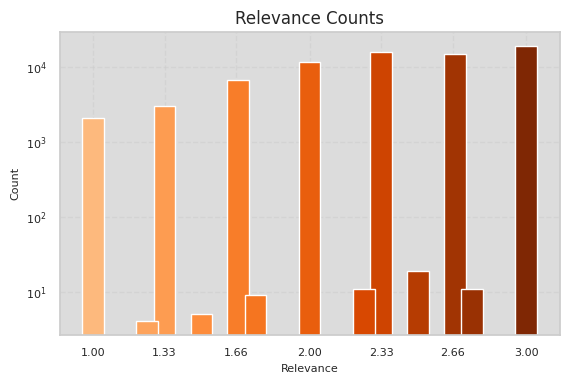

In [12]:
# Count the occurrences of each relevance level
relevance_counts = train['relevance'].value_counts()

# Create a colormap
cmap = plt.cm.get_cmap('Oranges')

# Plotting with customizations
plt.figure(figsize=(6, 4))  # Adjust figure size
plt.gca().set_facecolor('gainsboro')  # Set background color to light grey
bar_width = 0.1  # Set the width of each bar
plt.bar(relevance_counts.index, relevance_counts.values, width=bar_width, color=cmap(relevance_counts.index/3))  # Set bar width and colors
plt.grid(True, linestyle='--', alpha=0.5)  # Add grid lines with custom style
plt.xlabel('Relevance', fontsize=8)  # Set x-axis label with fontsize
plt.ylabel('Count', fontsize=8)  # Set y-axis label with fontsize
plt.title('Relevance Counts', fontsize=12)  # Set title with fontsize
plt.xticks(fontsize=8, ticks=[1, 1.33, 1.66, 2, 2.33, 2.66, 3])  # Set x-axis tick labels fontsize and values
plt.yticks(fontsize=8)  # Set y-axis tick labels fontsize
plt.tight_layout()  # Adjust layout to prevent labels from being cut off
plt.yscale('log')  # Set y-axis scale to log

# Display the plot
plt.show()

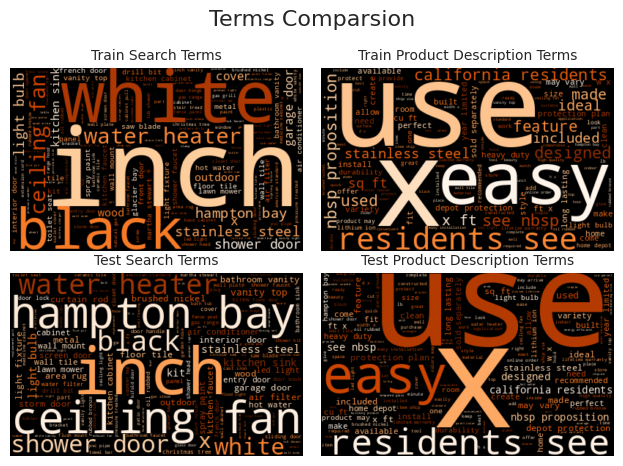

In [148]:
# Create a big plot with 4 subplots
fig, axs = plt.subplots(2, 2)

# Plot train search terms
create_word_cloud_subplot(train, 'search_term', 'Train Search Terms', axs[0, 0])
create_word_cloud_subplot(train, 'combined_text', 'Train Product Description Terms', axs[0, 1])

# Plot test search terms
create_word_cloud_subplot(test, 'search_term', 'Test Search Terms', axs[1, 0])
create_word_cloud_subplot(test, 'combined_text', 'Test Product Description Terms', axs[1, 1])

# Manually adjust the spacing between rows
plt.suptitle("Terms Comparsion", fontsize=16)
fig.tight_layout()
plt.show()

In [150]:
# Calculate length of search terms and product_description
train['search_term_length'] = train['search_term'].apply(lambda x: len(str(x)))
train['combined_text_length'] = train['combined_text'].apply(lambda x: len(str(x)))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


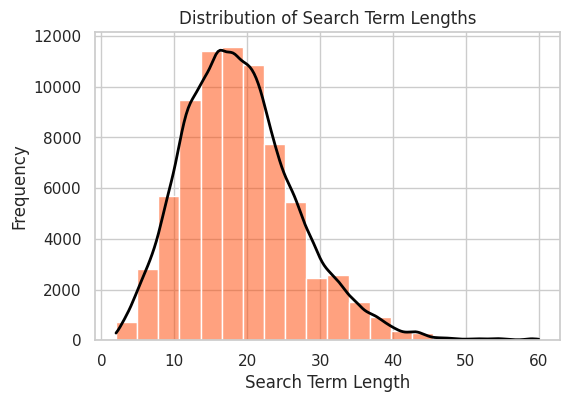

In [152]:
plot_hist(train, 'search_term_length', 'Distribution of Search Term Lengths', 'Search Term Length')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


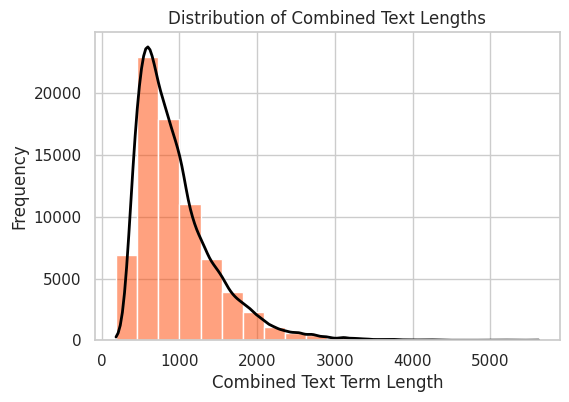

In [151]:
plot_hist(train, 'combined_text_length', 'Distribution of Combined Text Lengths', 'Combined Text Term Length')

In [49]:
text, search, des = create_texts(train, test)
char2i = get_char2i(text)

search_lengths = search.apply(len)
des_lengths = des.apply(len)

# Calculate the average length
average_search_length = search_lengths.mean()
average_des_length = des_lengths.mean()

# Output the average length
print("Average search length:", int(average_search_length))
print("Average combined text length:", int(average_des_length))

Average search length: 18
Average combined text length: 960


## 2. Preprocessing

In [50]:
def tokenize_term(search_term, length):
    """
    Tokenizes a search term by mapping characters to their corresponding indices and padding/truncating to a fixed length.

    Parameters:
    - search_term (str): The search term to tokenize.
    - length (int): The desired length of the tokenized sequence.

    Returns:
    - List[int]: A list of token indices representing the search term, padded or truncated to the specified length.
    """
    tokens = [char2i[char] for char in search_term]
    if len(tokens) < length:
        tokens += [0] * (length - len(tokens))
    elif len(tokens) > length:
        tokens = tokens[:length]
    return tokens

def get_tok_example(i, text):
    """
    Prints the original search term example, its length, and the tokenized version.

    Parameters:
    - i (int): Index of the example in the DataFrame.
    - text (str): A string indicating whether the example is a search term or combined text.

    Returns:
    - None
    """
    example = train_example.iloc[i]
    search_example = example['search_term']
    tok_example = train.iloc[i]['search_term']
    print(f'Search example: {search_example}')
    print(f'Length of example: {len(search_example)} ({text})')
    print(f'Search example after tokenization: {tok_example}')

#### The average combined text length is 960 characters. Since the combined text contains a lot of information, with the most important details usually found at the beginning, I'll shorten it to just 500 characters.

In [51]:
# Tokenize search terms and combined text in the train DataFrame
train['search_term'] = train['search_term'].apply(tokenize_term, length=18)
train['combined_text'] = train['combined_text'].apply(tokenize_term, length=500)

# Tokenize search terms and combined text in the test DataFrame
test['search_term'] = test['search_term'].apply(tokenize_term, length=18)
test['combined_text'] = test['combined_text'].apply(tokenize_term, length=500)

In [52]:
train.head()

,id,product_uid,search_term,relevance,combined_text
0,2,100001,"[4, 67, 19, 43, 26, 38, 25, 69, 4, 56, 81, 26,...",3.00,"[37, 46, 35, 18, 37, 21, 67, 38, 37, 59, 69, 2..."
1,3,100001,"[43, 38, 25, 69, 4, 56, 81, 26, 59, 0, 0, 0, 0...",2.50,"[37, 46, 35, 18, 37, 21, 67, 38, 37, 59, 69, 2..."
2,9,100002,"[23, 26, 56, 81, 38, 21, 44, 26, 69, 0, 0, 0, ...",3.00,"[25, 26, 76, 69, 38, 18, 69, 26, 35, 46, 3, 35..."
3,16,100005,"[69, 4, 46, 67, 38, 37, 76, 21, 66, 26, 69, 38...",2.33,"[23, 26, 43, 59, 4, 38, 44, 26, 69, 21, 38, 8,..."
4,17,100005,"[37, 76, 21, 66, 26, 69, 38, 21, 67, 43, 33, 3...",2.67,"[23, 26, 43, 59, 4, 38, 44, 26, 69, 21, 38, 8,..."


### Tokenization examples

In [41]:
train_example, test_example = load_data()

In [42]:
get_tok_example(0, "lower than average")

Search example: angle bracket
Length of example: 13 (lower than average)
Search example after tokenization: [54, 12, 44, 13, 53, 68, 58, 39, 54, 28, 24, 53, 10, 0, 0, 0, 0, 0]


In [43]:
get_tok_example(6, "bigger than average")

Search example: microwave over stove
Length of example: 20 (bigger than average)
Search example after tokenization: [75, 50, 28, 39, 67, 15, 54, 33, 53, 68, 67, 33, 53, 39, 68, 57, 10, 67]


## 3. Models

### 3.a Benchmark model - XGBRegressor

In [14]:
def get_xgb_df():
    """
    Prepares data for XGBoost model training and evaluation.

    Returns:
    - tuple: A tuple containing X_train, y_train, X_test, and y_test arrays.
    """
    # Load training and testing data
    train, test = load_data()

    # Vectorize text data using character-level analysis
    vectorizer = CountVectorizer(analyzer='char')
    combined_text_train = vectorizer.fit_transform(train['combined_text']).toarray()
    search_train = vectorizer.transform(train['search_term']).toarray()
    combined_text_test = vectorizer.transform(test['combined_text']).toarray()
    search_test = vectorizer.transform(test['search_term']).toarray()

    # Concatenate vectorized features
    X_train = np.concatenate((combined_text_train, search_train), axis=1)
    y_train = train['relevance']

    X_test = np.concatenate((combined_text_test, search_test), axis=1)
    y_test = test['relevance']
    return X_train, y_train, X_test, y_test


def get_metrics_xgb(y_pred_train, y_train, y_pred_test, y_test):
    """
    Computes evaluation metrics for XGBoost model predictions.

    Parameters:
    - y_pred_train (array-like): Predicted relevance scores for the training set.
    - y_train (array-like): Actual relevance scores for the training set.
    - y_pred_test (array-like): Predicted relevance scores for the test set.
    - y_test (array-like): Actual relevance scores for the test set.

    Returns:
    - DataFrame: A DataFrame containing evaluation metrics for the XGBoost model.
    """
    # Calculate MAE
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)

    # Calculate RMSE
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    # Create DataFrame
    df = pd.DataFrame({
        'Model type': ['XGB benchmark'],
        'Train RMSE': [rmse_train],
        'Test-RMSE': [rmse_test],
        'Train MAE': [mae_train],
        'Test-MAE': [mae_test],
        'Runtime': [xgb_time],
    })

    return df


def column_scatter_plot(df, figsize=(8, 6), jitter=0.3, alpha=0.05):
    """
    Create a column scatter plot with mean lines for each group.

    Parameters:
    - test_df (DataFrame): DataFrame containing 'relevance' and 'predicted relevance' columns.
    - figsize (tuple, optional): Size of the figure. Default is (8, 6).
    - jitter (float, optional): Amount of jitter to apply to the data points. Default is 0.3.
    - alpha (float, optional): Transparency of the data points. Default is 0.05.
    """
    # Set the size of the figure
    plt.figure(figsize=figsize)
    sns.set(style='whitegrid')

    # Define the number of colors you want in the palette
    num_colors = len(df['relevance'].unique())

    # Choose a continuous color palette
    palette = sns.color_palette("viridis", as_cmap=True, n_colors=num_colors)

    # Create a column scatter plot with seaborn using the chosen palette
    sns.stripplot(x='relevance', y='predicted relevance', hue='relevance', edgecolor='black', legend=False,
                  data=df, jitter=jitter, alpha=alpha, palette=palette, zorder=1)

    # Add labels and title
    plt.xlabel('Actual Relevance')
    plt.ylabel('Predicted Relevance')
    plt.title('Predicted vs. Actual Relevance')

    # Show the plot
    plt.show()
    

X_train, y_train, X_test, y_test = get_xgb_df()

In [15]:
# Define the parameters
param_grid = {
    'learning_rate': [0.1, 0.01],
    'n_estimators': [50, 100],
    'max_depth': [3,5,7],
}

# Create a GradientBoostingClassifier
base_model = XGBRegressor()

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, cv=5,
                           scoring=make_scorer(mean_squared_error, squared=False))

# Fit the model to the training data with grid search
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

Best parameters found by GridSearchCV:
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}


In [16]:
# Define the evaluation set
eval_set = [(X_train, y_train), (X_test, y_test)]

# Use the best model for training
t = time.time()

# Train the model with RMSE as the evaluation metric
best_model.fit(X_train, y_train, eval_set=eval_set, eval_metric="rmse", verbose=False)

xgb_time = time.time() - t
# Predict on the test data
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


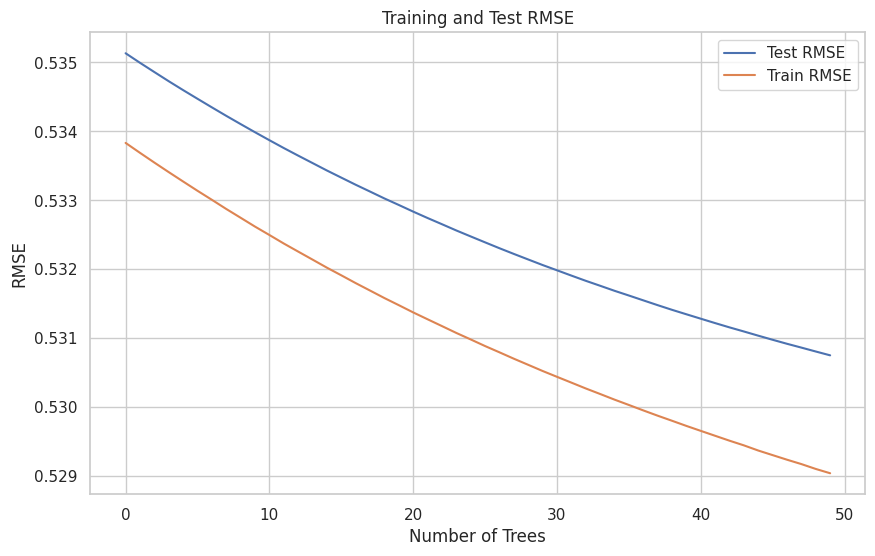

In [17]:
# Get the training and validation RMSE from the training history
train_rmse = best_model.evals_result()['validation_0']['rmse']
val_rmse = best_model.evals_result()['validation_1']['rmse']

# Plot the training and validation loss graphs
plt.figure(figsize=(10, 6))
plt.plot(val_rmse, label='Test RMSE')
plt.plot(train_rmse, label='Train RMSE')
plt.xlabel('Number of Trees')
plt.ylabel('RMSE')
plt.title('Training and Test RMSE')
plt.legend()
plt.show()

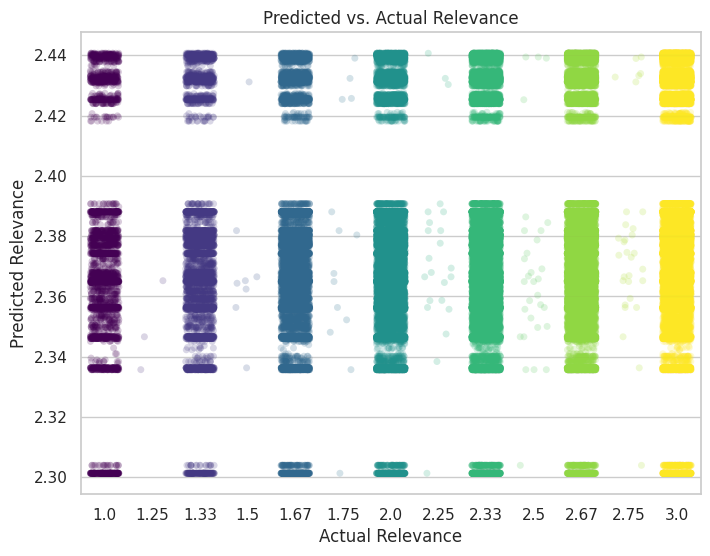

In [22]:
test['predicted relevance'] = y_pred_test
column_scatter_plot(test, alpha=0.2)

In [46]:
new_test = test.copy()
new_test.loc[:, 'predicted relevance'] = y_pred_test
new_test[['relevance', 'predicted relevance']].describe()

,relevance,predicted relevance
count,112067.000000,112067.000000
mean,2.380525,2.382245
std,0.535274,0.034301
min,1.000000,2.301357
25%,2.000000,2.359344
50%,2.330000,2.376026
75%,3.000000,2.423943
max,3.000000,2.440651


In [25]:
xgb_df = get_metrics_xgb(y_pred_train, y_train, y_pred_test, y_test)
xgb_df

,Model type,Train RMSE,Test-RMSE,Train MAE,Test-MAE,Runtime
0,XGB benchmark,0.529045,0.530754,0.43262,0.433707,9.961358


### Explanation: 
#### The predictions generated by the XGB model closely align with the mean relevance. The predicted relevance exhibits minimal variance (0.03 compared to 0.53), indicating that the model predominantly forecasts values in close proximity to the mean. This suggests that the model's performance is suboptimal.

### 3.b Character level LSTM

In [6]:
class SearchDataset(Dataset):
    """
    Dataset class for loading pairs of images and their corresponding labels.

    Args:
    - df (DataFrame): The dataframe containing search_term and product_description.

    Methods:
    - __getitem__: Retrieves a sample from the dataset at the specified index.
    - __len__: Returns the total number of samples in the dataset.
    """

    def __init__(self, df):
        self.df = df

    def __getitem__(self, idx):
        search_term = torch.tensor(self.df.iloc[idx]['search_term'], dtype=torch.long)
        combined_text = torch.tensor(self.df.iloc[idx]['combined_text'], dtype=torch.long)
        relevance = torch.tensor(self.df.iloc[idx]['relevance'], dtype=torch.float32)
        return search_term, combined_text, relevance

    def __len__(self):
        return len(self.df)

In [7]:
class SearchDataModule(L.LightningDataModule):
    """
    Lightning DataModule for handling search data loading and processing.

    Parameters:
    - train_data (DataFrame): DataFrame containing training data.
    - val_data (DataFrame): DataFrame containing validation data.
    - test_data (DataFrame): DataFrame containing test data.
    - batch_size (int): Batch size for DataLoader (default is 64).

    Methods:
    - train_dataloader(): Returns DataLoader for training data.
    - val_dataloader(): Returns DataLoader for validation data.
    - test_dataloader(): Returns DataLoader for test data.
    """
    def __init__(self, train_data, val_data, test_data, batch_size=64):
        super().__init__()
        self.train_df = train_data
        self.val_df = val_data
        self.test_df = test_data
        self.batch_size = batch_size

    def train_dataloader(self):
        train_dataset = SearchDataset(self.train_df)
        return DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        val_dataset = SearchDataset(self.val_df)
        return DataLoader(val_dataset, batch_size=self.batch_size, num_workers=4)

    def test_dataloader(self):
        test_dataset = SearchDataset(self.test_df)
        return DataLoader(test_dataset, batch_size=self.batch_size, num_workers=4)

In [8]:
class SiameseNetwork(L.LightningModule):
    def __init__(self, model_hparams, optimizer_name, optimizer_hparams):
        """
        Siamese Network model for image similarity learning.

        Args:
        - model_hparams (dict): Hyperparameters for the model.
        - optimizer_name (str): Name of the optimizer to use. Supported options: "Adam", "SGD".
        - optimizer_hparams (dict): Hyperparameters for the optimizer.

        Attributes:
        - dropout (float): Dropout probability.
        - hidden_size (int): Hidden size for LSTM.
        - num_layers (int): Number of LSTM layers.
        - search_lstm (nn.LSTM): LSTM layer for search term.
        - description_lstm (nn.LSTM): LSTM layer for product description.
        - fc (nn.Linear): Fully connected layers.
        - loss_module (nn.MSELoss): Mean Squared Error loss function.
        - mae (callable): Mean Absolute Error function.
        - rmse (callable): Root Mean Squared Error function.
        """
        super().__init__()

        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()

        self.dropout = model_hparams['dropout']
        self.hidden_size = model_hparams['hidden_size']
        self.num_layers = model_hparams['num_layers']
        self.num_embeddings = model_hparams['num_embeddings']
        self.embedding_dim = 64
        
        self.embedding = nn.Embedding(num_embeddings= self.num_embeddings+1, embedding_dim=self.embedding_dim)
        
        self.search_lstm = nn.LSTM(input_size=self.embedding_dim,
                            hidden_size=self.hidden_size,
                            num_layers=self.num_layers,
                            dropout=self.dropout,
                            bidirectional=True,
                            batch_first=True)
        
        self.description_lstm = nn.LSTM(input_size=self.embedding_dim,
                            hidden_size=self.hidden_size,
                            num_layers=self.num_layers,
                            dropout=self.dropout,
                            bidirectional=True,
                            batch_first=True)

        # Setting up the fully connected layers (concatenate 3 outputs in double size(bidirectional) = 6)
        self.fc = nn.Linear(6*self.hidden_size, 1)

        # MAE Calculator
        self.MAE =  F.l1_loss
        
    
    def rmse_loss(self, predicted, target):
        """
        Calculates the Root Mean Squared Error (RMSE) between predicted and target values.

        Args:
        - predicted (torch.Tensor): Predicted values.
        - target (torch.Tensor): Target values.

        Returns:
        - rmse (torch.Tensor): Root Mean Squared Error.
        """
        mse = F.mse_loss(predicted, target)
        rmse = torch.sqrt(mse)
        return rmse

        
    def forward(self, search_term, product_description):
        search_term = self.embedding(search_term)
        product_description = self.embedding(product_description)
        output1, h1 = self.search_lstm(search_term)
        embedding1 = torch.mean(output1, dim=1)
        output2, h2 = self.description_lstm(product_description)
        embedding2 = torch.mean(output2, dim=1)
        dist = torch.abs(embedding1 - embedding2) 
        concatenated_vectors = torch.cat((embedding1, embedding2, dist), dim=1)
        concatenated_vectors = torch.relu(concatenated_vectors)
        pred_relevance = self.fc(concatenated_vectors).squeeze()
        return pred_relevance

    def configure_optimizers(self):
        # We will support Adam or SGD as optimizers.
        if self.hparams.optimizer_name == "Adam":
            # AdamW is Adam with a correct implementation of weight decay (see here
            optimizer = optim.AdamW(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, f'Unknown optimizer: "{self.hparams.optimizer_name}"'

        # We will reduce the learning rate by 0.1 after 100 and 150 epochs
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,100], gamma=0.1)
        return [optimizer], [scheduler]


    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        search_term, combined_text, labels = batch
        preds = self(search_term, combined_text)
        RMSE_loss = self.rmse_loss(preds, labels)
        MAE = self.MAE(preds, labels)
        # Log per epoch 
        self.log("train_loss", RMSE_loss, on_step=False, on_epoch=True, logger=True, prog_bar=True)
        self.log("train_MAE", MAE, on_step=False, on_epoch=True, logger=True, prog_bar=True)
        return RMSE_loss  # Return tensor to call ".backward" on

    def validation_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        search_term, combined_text, labels = batch
        preds = self(search_term, combined_text)
        RMSE_loss = self.rmse_loss(preds, labels)
        MAE = self.MAE(preds, labels)
        # Log per epoch 
        self.log("val_loss", RMSE_loss, on_step=False, on_epoch=True, logger=True, prog_bar=True)
        self.log("val_MAE", MAE, on_step=False, on_epoch=True, logger=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        search_term, combined_text, labels = batch
        preds = self(search_term, combined_text)
        RMSE_loss = self.rmse_loss(preds, labels)
        MAE = self.MAE(preds, labels)
        # Log per epoch 
        self.log("test_loss", RMSE_loss, on_step=False, on_epoch=True, logger=True, prog_bar=True)
        self.log("test_MAE", MAE, on_step=False, on_epoch=True, logger=True, prog_bar=True)

In [9]:
def train_model(model_name, cp_path, batch_size, max_epochs, train_df, val_df, test_df, save_name=None, **kwargs):
    """
    Train a specified model on the provided data.

    Args:
    - model_name (str): Name of the model to run.
    - cp_path (str): Path to the checkpoint file for pretrained model. If None, trains from scratch.
    - batch_size (int): Batch size for training.
    - max_epochs (int): Maximum number of epochs for training.
    - train_df (DataFrame): DataFrame containing training data.
    - val_df (DataFrame): DataFrame containing validation data.
    - test_df (DataFrame): DataFrame containing test data.
    - save_name (str, optional): Name for saving checkpoints and logs. If None, defaults to model_name.

    Returns:
    - model: Trained model instance.
    - result (dict): Dictionary containing test loss and validation loss (if applicable).
    - best_model_path (str): Path to the best model checkpoint.
    """
    if save_name is None:
        save_name = model_name

    # Create a PyTorch Lightning trainer with the generation callback
    cp_callback  = ModelCheckpoint(
                save_weights_only=True, mode="min", monitor="val_loss")

    early_stop_callback = EarlyStopping(
                monitor='val_loss',  # Monitor validation loss for improvement
                min_delta=0.001,      # Minimum change in monitored quantity to qualify as an improvement
                patience=5,           # Number of epochs with no improvement after which training will be stopped
                verbose=False          # Print early stopping information
                )

    neptune_logger = NeptuneLogger(
    project="odedreg/Assignment3",
    name=f'Find-HyperParams {model_name}',
    tags=[f'Find-HyperParams {model_name}'],
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiMjQ4YmQ0NS02ODcwLTQ2MjEtYTk5OS0zYTAzYTA1ZDViNTUifQ==",
    log_model_checkpoints=False,
    )

    trainer = L.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),  # Where to save models
        # We run on a single GPU (if possible)
        accelerator="auto",
        devices=1,
        logger=neptune_logger,
        # How many epochs to train for if no patience is set
        max_epochs=max_epochs,
        callbacks=[early_stop_callback,
            cp_callback,  # Save the best checkpoint based on the maximum val_loss recorded. Saves only weights and not optimizer
            LearningRateMonitor("epoch"),
        ],  # Log learning rate every epoch
    )  # In case your notebook crashes due to the progress bar, consider increasing the refresh rate

    trainer.logger._log_graph = True  # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    model_hparams = kwargs.get('model_hparams')
    optimizer_name = kwargs.get('optimizer_name')
    optimizer_name = {'optimizer_name': optimizer_name}
    optimizer_hparams = kwargs.get('optimizer_hparams')

    all_hyperparams = {**model_hparams, **optimizer_name, **optimizer_hparams}
    neptune_logger.log_hyperparams(params=all_hyperparams)

    # Check whether pretrained model exists. If yes, load it and skip training
    if cp_path != None:
        print(f"Found pretrained model at {cp_path}, loading...")
        # Automatically loads the model with the saved hyperparameters
        if model_name == 'Character level LSTM' or model_name == 'Word Level LSTM':
            model = SiameseNetwork.load_from_checkpoint(cp_path)
        elif model_name == 'LM':
            model = LMSiameseClassifier.load_from_checkpoint(cp_path)
        else:
            print("Model Error")
    else:
        if model_name == 'Character level LSTM'or model_name == 'Word Level LSTM':
            model = SiameseNetwork(**kwargs)
        elif model_name == 'LM':
            model = LMSiameseClassifier(**kwargs)
        else:
            print("Model Error")
            
    if model_name == 'Character level LSTM'or model_name == 'Word Level LSTM':
        dm = SearchDataModule(train_df, val_df, test_df, batch_size=batch_size)
    elif model_name == 'LM':
        dm = LMDataModule(train_df, val_df, test_df, batch_size=batch_size)
    else:
        print("Model Error")
            
    trainer.fit(model, dm)
    
    # Load best checkpoint after training
    if model_name == 'Character level LSTM' or model_name == 'Word Level LSTM':
        model = SiameseNetwork.load_from_checkpoint(
              trainer.checkpoint_callback.best_model_path) 
    elif model_name == 'LM':
        model = LMSiameseClassifier.load_from_checkpoint(
              trainer.checkpoint_callback.best_model_path) 
        
    # Test best model on validation and test set
    test_result = trainer.test(model, dataloaders=dm.test_dataloader(), verbose=False)
    val_result = trainer.test(model, dataloaders=dm.val_dataloader(), verbose=False)
    result = {"test": test_result[0]["test_loss"], "val": val_result[0]["test_loss"]}
    return model, result, cp_callback.best_model_path, neptune_logger

In [10]:
# Perform Training and Evaluation on the provided data, measures time and clear cache from cuda
def test_model(model_name, cp_path, batch_size, max_epochs, train_df, val_df, test_df, model_hparams, optimizer_name, optimizer_hparams):
    """
    Perform Training and Evaluation on the provided data, measures time and clear cache from cuda

    Args:
    - model_name (str): Name of the model to run.
    - cp_path (str): Path to the checkpoint file for pretrained model. If None, trains from scratch.
    - batch_size (int): Batch size for training.
    - max_epochs (int): Maximum number of epochs for training.
    - train_df (DataFrame): DataFrame containing training data.
    - val_df (DataFrame): DataFrame containing validation data.
    - test_df (DataFrame): DataFrame containing test data.
    - model_hparams (dict): Hyperparameters for the model.
    - optimizer_name (str): Name of the optimizer to use. Supported options: "Adam", "SGD".
    - optimizer_hparams (dict): Hyperparameters for the optimizer.

    Returns:
    - chosen_model: Trained model instance.
    - model_results (dict): Dictionary containing test loss and validation loss (if applicable).
    - cp_path_new (str): Path to the best model checkpoint.
    - total_time (float): Total time taken for training and evaluation.
    """
    t = time.time()
    chosen_model, model_results, cp_path_new, neptune_logger = train_model(
    model_name=model_name,
    cp_path = cp_path,
    batch_size = batch_size,
    max_epochs = max_epochs,
    train_df = train_df,
    val_df = val_df,
    test_df = test_df,
    model_hparams=model_hparams,
    optimizer_name = optimizer_name,
    optimizer_hparams = optimizer_hparams
    )

    total_time = time.time() - t
    neptune_logger.experiment.stop()
    torch.cuda.empty_cache()

    return (chosen_model, model_results, cp_path_new, total_time)

In [11]:
def get_params_list(dropout_list, lr_list, weight_decay_list, num_embeddings):
    """
    Generate a list of parameter combinations for training the model.

    Args:
    - dropout_list (list): List of dropout values to try.
    - lr_list (list): List of learning rates to try.
    - weight_decay_list (list): List of weight decay values to try.

    Returns:
    - params_list (list): List of tuples, each containing a dictionary of model hyperparameters,
      the optimizer name, and a dictionary of optimizer hyperparameters.
    """
    params_list = []
    for dropout_value in dropout_list:
        for lr_value in lr_list:
            for weight_decay_value in weight_decay_list:
                  params_list.append(({'hidden_size': 64,
                                        'num_layers': 1,
                                        'dropout' : dropout_value,
                                        'num_embeddings': num_embeddings},
                                      "Adam",
                                      {"lr": lr_value,
                                       "weight_decay": weight_decay_value}))
    return params_list

In [12]:
def grid_search(params_list, X_train_grid, X_val_grid, X_test_grid, model_name, batch_size, max_epochs):
    """
    Perform grid search over the provided parameter combinations.

    Args:
    - params_list (list): List of parameter combinations, each containing model hyperparameters,
    optimizer name, and optimizer hyperparameters.
    - max_epochs (int): Maximum number of epochs for training.

    Returns:
    - hyper_params_list (list): List of tuples, each containing a string representation of the
    hyperparameters and the corresponding validation loss.
    """
    hyper_params_list = []
    for config in params_list:
        model_hparams = config[0]
        optimizer_name = config[1]
        optimizer_hparams = config[2]
        chosen_model, model_results, cp_path_new, total_time = test_model(
        model_name = model_name,
        cp_path = None,
        batch_size = batch_size,
        max_epochs = max_epochs,
        train_df = X_train_grid,
        val_df = X_val_grid,
        test_df = X_test_grid,
        model_hparams = model_hparams,
        optimizer_name = optimizer_name,
        optimizer_hparams = optimizer_hparams,
        )
        results_val = model_results['val']
        hyper_params_list.append((f"params:\n{model_hparams}\n{optimizer_hparams},  validation loss: {np.round(results_val,3)}\n", np.round(results_val,3)))
    return hyper_params_list

In [13]:
def print_grid_search(hyper_params_list):
    """
    Print the results of the grid search and the best hyperparameters found.

    Args:
    - hyper_params_list (list): List of tuples, each containing a string representation of the
    hyperparameters and the corresponding validation loss.
    """
    best_hyper_params = min(hyper_params_list, key=lambda item: item[1])[0]
    print(f'\nBest hyperparameters: {best_hyper_params}\n')
    print('Grid Search results:')
    for x in hyper_params_list:
        print(x[0])

In [34]:
def get_relevance(df, model, DataModule):
    """
    Generates predicted relevance scores for a DataFrame using the provided model.

    Parameters:
    - df (DataFrame): DataFrame containing search data.
    - model: A trained model for predicting relevance scores.

    Returns:
    - list: A list containing the predicted relevance scores.
    """
    # Set the model to evaluation mode
    model.eval()
    
    # Create a DataModule instance for the provided DataFrame
    dm = DataModule(df, df, df, batch_size=256)
    
    # Initialize an empty list to store predicted relevance scores
    predicted_relevance = []
    
    # Disable gradient computation during inference
    with torch.no_grad():
        # Iterate over batches in the DataLoader
        for batch in tqdm(dm.train_dataloader()):
            # Extract search term, product description, and labels from the batch
            search_term, product_description, labels = batch
            # Perform forward pass to get predictions from the model
            preds = model(search_term, product_description)
            
            # Round the predicted relevance scores to two decimal places
            rounded_preds = [round(pred.item(), 2) for pred in preds]
            
            # Extend the list of predicted relevance scores
            predicted_relevance.extend(rounded_preds)
    
    # Return the predicted relevance scores as a list
    return predicted_relevance

In [15]:
# Sampling a smaller subset of the train and test data
small_train = train.sample(n=10000, random_state=42)
small_test = test.sample(n=3000, random_state=42)

# Resetting index for the sampled DataFrames
small_train.reset_index(drop=True, inplace=True)
small_test.reset_index(drop=True, inplace=True)

# Splitting the sampled train data into train and validation sets
small_train_df, small_val_df = train_test_split(small_train, test_size=0.2, random_state=42)

# Resetting index for the split DataFrames
small_train_df.reset_index(drop=True, inplace=True)
small_val_df.reset_index(drop=True, inplace=True)

# Creating a copy of the sampled test data for consistency
small_test_df = small_test.copy()

### Grid search to find optimal Hyper-params

In [ ]:
variable_model = 'Character level LSTM'
dropout_list = [0, 0.3]
lr_list = [1e-2, 1e-3, 1e-4]
weight_decay_list = [0.01, 0.1]
params_list = get_params_list(dropout_list, lr_list, weight_decay_list,  len(char2i))
hyper_params_list = grid_search(params_list, small_train_df, small_val_df, small_test_df, variable_model, 256, 20)

In [ ]:
print_grid_search(hyper_params_list)


Best hyperparameters: params:
{'hidden_size': 64, 'num_layers': 1, 'dropout': 0.3, 'num_embeddings': 86}
{'lr': 0.01, 'weight_decay': 0.01},  validation loss: 0.518


Grid Search results:
params:
{'hidden_size': 64, 'num_layers': 1, 'dropout': 0, 'num_embeddings': 86}
{'lr': 0.01, 'weight_decay': 0.01},  validation loss: 0.522

params:
{'hidden_size': 64, 'num_layers': 1, 'dropout': 0, 'num_embeddings': 86}
{'lr': 0.01, 'weight_decay': 0.1},  validation loss: 0.521

params:
{'hidden_size': 64, 'num_layers': 1, 'dropout': 0, 'num_embeddings': 86}
{'lr': 0.001, 'weight_decay': 0.01},  validation loss: 0.521

params:
{'hidden_size': 64, 'num_layers': 1, 'dropout': 0, 'num_embeddings': 86}
{'lr': 0.001, 'weight_decay': 0.1},  validation loss: 0.526

params:
{'hidden_size': 64, 'num_layers': 1, 'dropout': 0, 'num_embeddings': 86}
{'lr': 0.0001, 'weight_decay': 0.01},  validation loss: 0.532

params:
{'hidden_size': 64, 'num_layers': 1, 'dropout': 0, 'num_embeddings': 86}
{'lr': 0.0001, 'we

### Runs 274-285

#### Loss comparsion (RMSE)

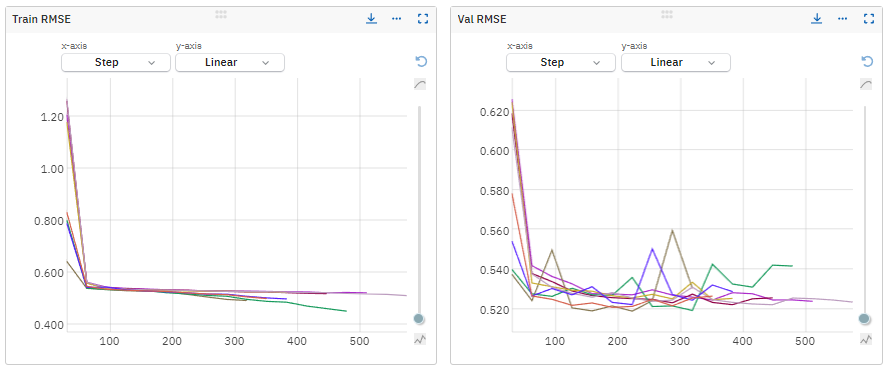

#### MAE comparsion

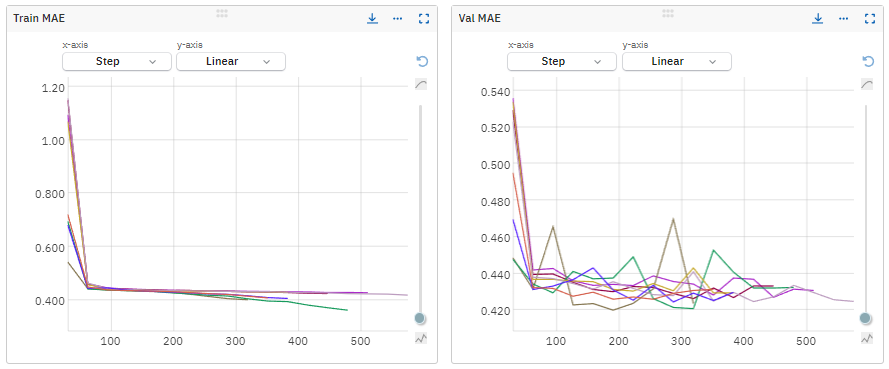

#### Chosen hyper-params:

#### Given the increased stability in convergence, I've opted for the following parameters: 
#### {'hidden_size': 64, 'num_layers': 1, 'dropout': 0, 'num_embeddings': 86}
#### {'lr': 0.001, 'weight_decay': 0.01},  validation loss: 0.521

In [ ]:
chosen_model, model_results, cp_path_new, total_time = test_model(
    model_name = 'Character level LSTM',
    cp_path = None,
    batch_size = 256,
    max_epochs = 25,
    train_df = train,
    val_df = test[:1500],
    test_df = test,
    model_hparams={'hidden_size': 64,
                    'num_layers': 1,
                    'dropout' : 0,
                    'num_embeddings': len(char2i)},
    optimizer_name = "Adam",
    optimizer_hparams = {"lr": 1e-3, "weight_decay": 0.01},
)

### Run 286

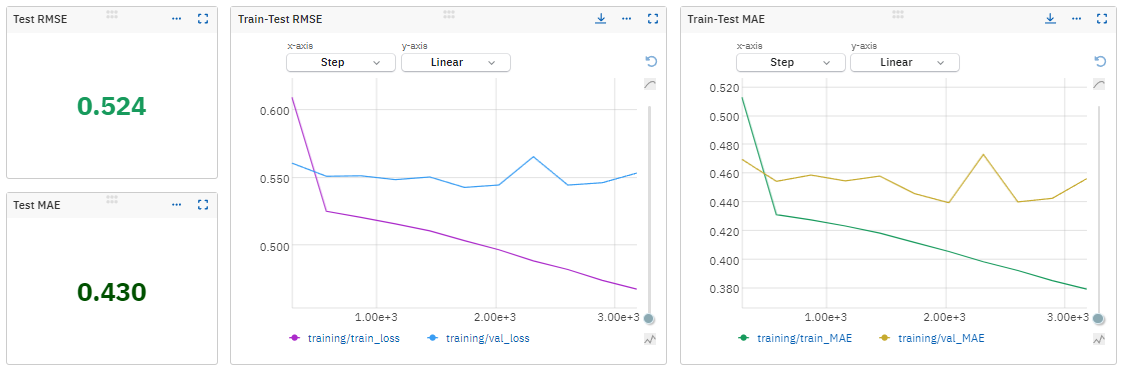

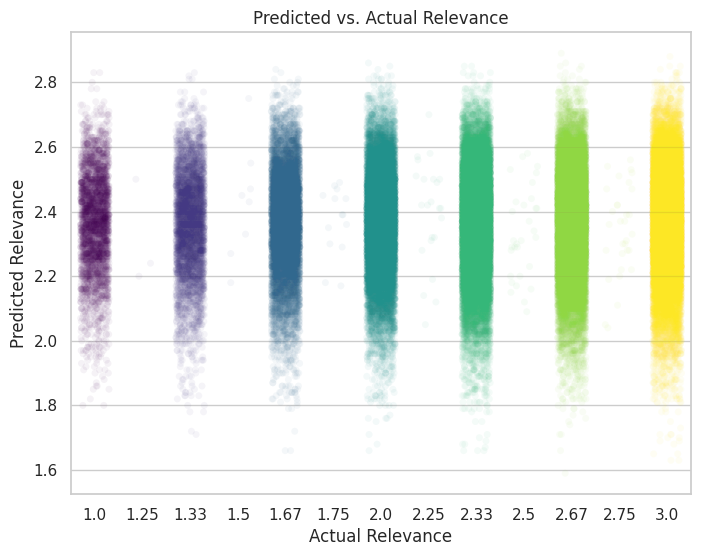

In [55]:
test.loc[:, 'predicted relevance'] = get_relevance(test, chosen_model, SearchDataModule)
column_scatter_plot(test)

In [56]:
test[['relevance', 'predicted relevance']].describe()

,relevance,predicted relevance
count,112067.000000,112067.000000
mean,2.380525,2.364303
std,0.535274,0.154033
min,1.000000,1.590000
25%,2.000000,2.260000
50%,2.330000,2.370000
75%,3.000000,2.470000
max,3.000000,2.890000


### Explanation: 
#### Char-Level LSTM achieved better RMSE and MAE results comapred to the xgboost model.
#### We observe that the model does not predict values lower than 1.59, which is problematic for low scores. Additionally, it generalizes well for scores around the median (2.38), but makes more mistakes towards the extremes of the relevance scale.

## 3.c Word Level LSTM

### Preprocessing

In [15]:
def text_to_words(text):
    """
    Tokenizes a given text into words using word_tokenize.

    Parameters:
    - text (str): The input text.

    Returns:
    - list: A list containing individual words of the input text.
    """
    return word_tokenize(text)

def create_texts(train, test):
    """
    Creates word-level representations of search terms and descriptions from train and test data.

    Parameters:
    - train (DataFrame): The DataFrame containing training data.
    - test (DataFrame): The DataFrame containing test data.

    Returns:
    - tuple: A tuple containing text, search, des, train, and test.
    """
    train['search_term'] = train['search_term'].apply(lambda x:text_to_words(x))
    test['search_term'] = test['search_term'].apply(lambda x:text_to_words(x))
    train['combined_text'] = train['combined_text'].apply(lambda x:text_to_words(x))
    test['combined_text'] = test['combined_text'].apply(lambda x:text_to_words(x))
    text = pd.concat([train['search_term'],test['search_term'], train['combined_text'],test['combined_text']], ignore_index=True)
    search = pd.concat([train['search_term'],test['search_term']], ignore_index=True)
    des = pd.concat([train['combined_text'],test['combined_text']], ignore_index=True)
    return text, search, des, train, test

def get_w2i(text):
    """
    Generates a word-to-index mapping for a given list of texts.

    Parameters:
    - text (list): A list containing word-level representations of texts.

    Returns:
    - dict: A dictionary mapping each unique word to its corresponding index.
    """
    unique_words = set()
    # Iterate over each list of words in the list and add them to the set
    for word_list in text:
        unique_words.update(word_list)

    # Create a dictionary mapping each unique word to an index
    w2i = {w: i+1 for i, w in enumerate(unique_words)}
    # Output the w2i dictionary
    return w2i

def tokenize_term(search_term, length, w2i):
    """
    Tokenizes a search term by mapping words to their corresponding indices and padding/truncating to a fixed length.

    Parameters:
    - search_term (list): The list of words representing the search term.
    - length (int): The desired length of the tokenized sequence.
    - w2i (dict): A dictionary mapping words to their corresponding indices.

    Returns:
    - list: A list of token indices representing the search term, padded or truncated to the specified length.
    """
    tokens = [w2i[w] for w in search_term]
    if len(tokens) < length:
        tokens += [0] * (length - len(tokens))
    elif len(tokens) > length:
        tokens = tokens[:length]
    return tokens


train, test = load_data()
text, search, des, train_df, test_df = create_texts(train, test)
w2i = get_w2i(text)

In [16]:
search_lengths = search.apply(len)
des_lengths = des.apply(len)

# Calculate the average length
average_search_length = search_lengths.mean()
average_des_length = des_lengths.mean()

# Output the average length
print("Average search length:", int(average_search_length))
print("Average combined text length:", int(average_des_length))

Average search length: 3
Average combined text length: 163


#### The average combined text length is 163 characters. Since the combined text contains a lot of information, with the most important details usually found at the beginning, I'll shorten it to just 64 tokens.

In [17]:
train_df['search_term'] = train_df['search_term'].apply(tokenize_term, length=3, w2i=w2i)
train_df['combined_text'] = train_df['combined_text'].apply(tokenize_term, length=64, w2i=w2i)

test_df['search_term'] = test_df['search_term'].apply(tokenize_term, length=3, w2i=w2i)
test_df['combined_text'] = test_df['combined_text'].apply(tokenize_term, length=64, w2i=w2i)

In [18]:
train_df.head()

,id,product_uid,search_term,relevance,combined_text
0,2,100001,"[63240, 15326, 0]",3.00,"[27947, 101908, 197248, 63240, 71719, 277060, ..."
1,3,100001,"[97008, 15326, 0]",2.50,"[27947, 101908, 197248, 63240, 71719, 277060, ..."
2,9,100002,"[281734, 17339, 0]",3.00,"[122417, 210324, 348090, 142242, 69125, 351665..."
3,16,100005,"[116531, 177144, 6614]",2.33,"[292162, 256457, 178139, 177144, 909, 191302, ..."
4,17,100005,"[177144, 909, 191302]",2.67,"[292162, 256457, 178139, 177144, 909, 191302, ..."


In [20]:
# Sampling a smaller subset of the train and test data
small_train = train.sample(n=10000, random_state=42)
small_test = test.sample(n=3000, random_state=42)

# Resetting index for the sampled DataFrames
small_train.reset_index(drop=True, inplace=True)
small_test.reset_index(drop=True, inplace=True)

# Splitting the sampled train data into train and validation sets
small_train_df, small_val_df = train_test_split(small_train, test_size=0.2, random_state=42)

# Resetting index for the split DataFrames
small_train_df.reset_index(drop=True, inplace=True)
small_val_df.reset_index(drop=True, inplace=True)

# Creating a copy of the sampled test data for consistency
small_test_df = small_test.copy()

### Grid search to find optimal Hyper-params

In [ ]:
variable_model = 'Word Level LSTM'
dropout_list = [0, 0.3]
lr_list = [1e-2, 1e-3, 1e-4]
weight_decay_list = [0.01, 0.1]
params_list = get_params_list(dropout_list, lr_list, weight_decay_list,  len(w2i))
hyper_params_list = grid_search(params_list, small_train_df, small_val_df, small_test_df, variable_model, 256, 20)

In [22]:
print_grid_search(hyper_params_list)


Best hyperparameters: params:
{'hidden_size': 64, 'num_layers': 1, 'dropout': 0, 'num_embeddings': 362144}
{'lr': 0.001, 'weight_decay': 0.1},  validation loss: 0.517


Grid Search results:
params:
{'hidden_size': 64, 'num_layers': 1, 'dropout': 0, 'num_embeddings': 362144}
{'lr': 0.01, 'weight_decay': 0.01},  validation loss: 0.526

params:
{'hidden_size': 64, 'num_layers': 1, 'dropout': 0, 'num_embeddings': 362144}
{'lr': 0.01, 'weight_decay': 0.1},  validation loss: 0.518

params:
{'hidden_size': 64, 'num_layers': 1, 'dropout': 0, 'num_embeddings': 362144}
{'lr': 0.001, 'weight_decay': 0.01},  validation loss: 0.519

params:
{'hidden_size': 64, 'num_layers': 1, 'dropout': 0, 'num_embeddings': 362144}
{'lr': 0.001, 'weight_decay': 0.1},  validation loss: 0.517

params:
{'hidden_size': 64, 'num_layers': 1, 'dropout': 0, 'num_embeddings': 362144}
{'lr': 0.0001, 'weight_decay': 0.01},  validation loss: 0.53

params:
{'hidden_size': 64, 'num_layers': 1, 'dropout': 0, 'num_embeddings': 3

### Runs 308-319

#### Loss comparsion (RMSE)

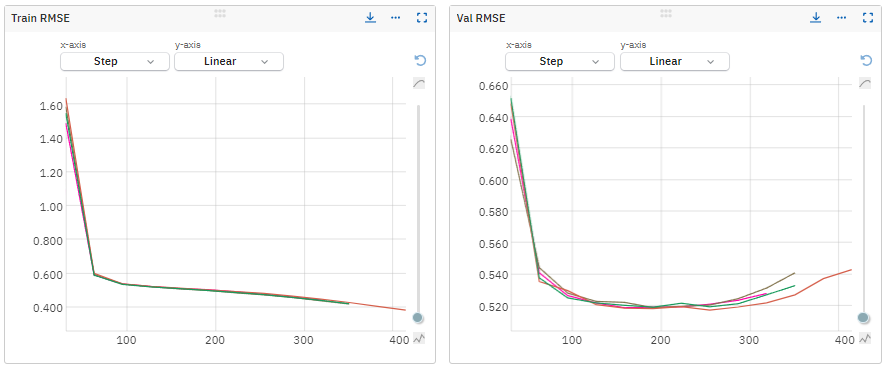

#### MAE comparsion 

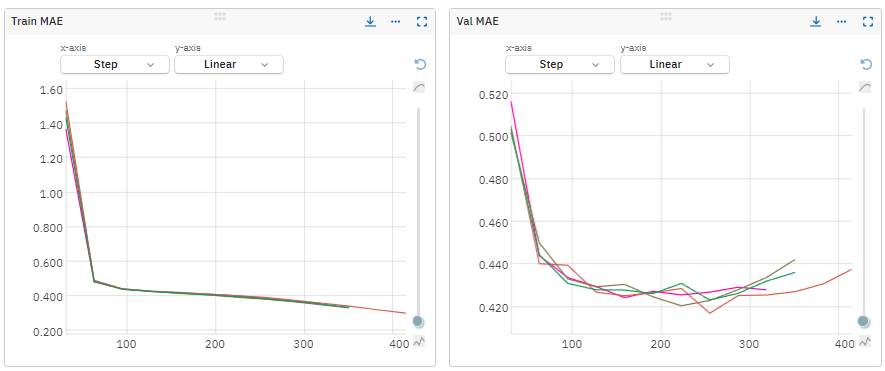

#### Chosen hyper-params:

#### {'hidden_size': 64, 'num_layers': 1, 'dropout': 0, 'num_embeddings': 362144}
#### {'lr': 0.001, 'weight_decay': 0.1},  validation loss: 0.517

In [ ]:
chosen_model, model_results, cp_path_new, total_time = test_model(
    model_name = 'Word Level LSTM',
    cp_path = None,
    batch_size = 256,
    max_epochs = 30,
    train_df = train_df,
    val_df = test_df,
    test_df = test_df,
    model_hparams={'hidden_size': 64,
                    'num_layers': 1,
                    'dropout' : 0,
                  'num_embeddings': len(w2i)},
    optimizer_name = "Adam",
    optimizer_hparams = {"lr": 0.001, "weight_decay": 0.1},
)
print(total_time/60)

### Run 322

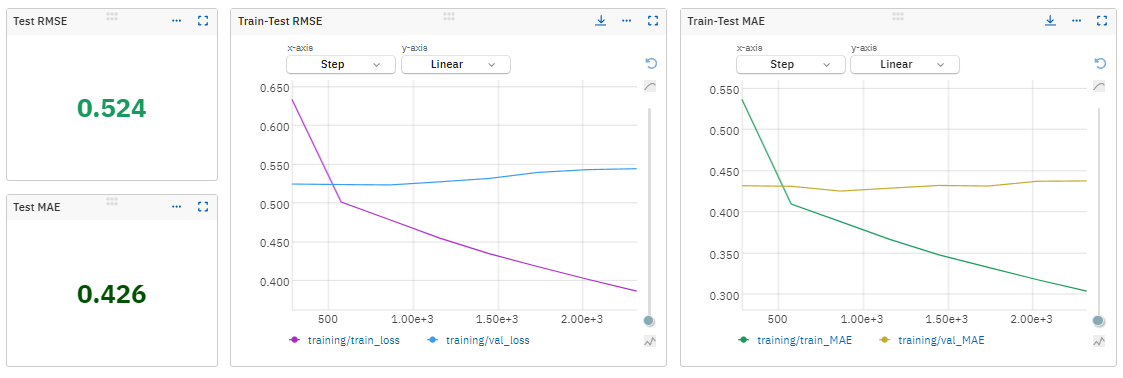

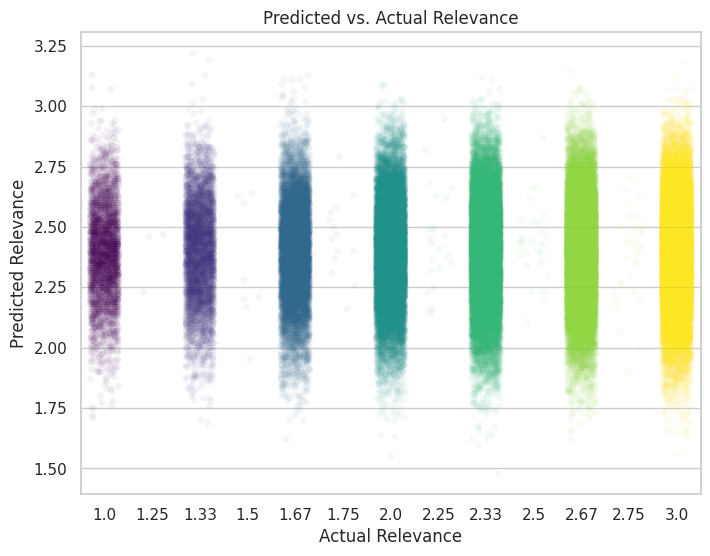

In [32]:
test.loc[:, 'predicted relevance'] = get_relevance(test, chosen_model, SearchDataModule)
column_scatter_plot(test)

In [33]:
test[['relevance', 'predicted relevance']].describe()

,relevance,predicted relevance
count,112067.000000,112067.000000
mean,2.380525,2.394324
std,0.535274,0.201489
min,1.000000,1.480000
25%,2.000000,2.260000
50%,2.330000,2.400000
75%,3.000000,2.530000
max,3.000000,3.220000


### Explanation: 
#### Word Level LSTM has slightly better MAE results than char-level model, while achieving the same rmse. We observe that the model does not predict values lower than 1.48, which is an improvement from the char-level model, but is still problematic for low scores. Additionally, it generalizes well for scores around the median (2.38), but makes more mistakes towards the extremes of the relevance scale.

### 3.d Language Model

In [15]:
train, test = load_data()
train.head()

,id,product_uid,search_term,relevance,combined_text
0,2,100001,angle bracket,3.00,simpson strong-tie 12-gauge angle: not only do...
1,3,100001,l bracket,2.50,simpson strong-tie 12-gauge angle: not only do...
2,9,100002,deck over,3.00,behr premium textured deckover 1-gal. #sc-141 ...
3,16,100005,rain shower head,2.33,delta vero 1-handle shower only faucet trim ki...
4,17,100005,shower only faucet,2.67,delta vero 1-handle shower only faucet trim ki...


In [16]:
#  Keep only 32 tokens in 'combined_text' column
train['combined_text'] = train['combined_text'].apply(lambda x: keep_first_n_words(x, 32))
test['combined_text'] = test['combined_text'].apply(lambda x: keep_first_n_words(x, 32))

In [17]:
class LMDataset(Dataset):
    """
    Dataset class for handling search data with search terms and product descriptions.

    Parameters:
    - df (DataFrame): DataFrame containing search data.

    Methods:
    - __getitem__(idx): Returns the search term, product description, and relevance label at the given index.
    - __len__(): Returns the number of samples in the dataset.
    """
    def __init__(self, df):
        self.df = df
        
    def __getitem__(self, idx):
        search_term = self.df['search_term'].iloc[idx]
        product_description = self.df['combined_text'].iloc[idx]
        
        label = self.df['relevance'].iloc[idx]
        label = torch.tensor(label, dtype=torch.float32)
        return search_term, product_description, label
    
    def __len__(self):
        return len(self.df)

In [18]:
class LMDataModule(L.LightningDataModule):
    """
    Lightning DataModule for handling search data loading and processing.

    Parameters:
    - train_data (DataFrame): DataFrame containing training data.
    - val_data (DataFrame): DataFrame containing validation data.
    - test_data (DataFrame): DataFrame containing test data.
    - batch_size (int): Batch size for DataLoader (default is 64).

    Methods:
    - train_dataloader(): Returns DataLoader for training data.
    - val_dataloader(): Returns DataLoader for validation data.
    - test_dataloader(): Returns DataLoader for test data.
    """
    def __init__(self, train_data, val_data, test_data, batch_size=64):
        super().__init__()
        self.train_df = train_data
        self.val_df = val_data
        self.test_df = test_data
        self.batch_size = batch_size

    def train_dataloader(self):
        train_dataset = LMDataset(self.train_df)
        return DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        val_dataset = LMDataset(self.val_df)
        return DataLoader(val_dataset, batch_size=self.batch_size, num_workers=4)

    def test_dataloader(self):
        test_dataset = LMDataset(self.test_df)
        return DataLoader(test_dataset, batch_size=self.batch_size, num_workers=4)

In [19]:
class LMSiameseClassifier(L.LightningModule):
    def __init__(self, model_hparams, optimizer_name, optimizer_hparams):
        """
        Inputs:
            model_hparams - Hyperparameters for the model, as dictionary.
            optimizer_name - Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams - Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
        """
        super().__init__()
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()
        self.dropout = model_hparams['dropout']
        
        self.model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device=device)
        
        # Dropout layer
        self.dropout = nn.Dropout(p=self.dropout)
        
        # Setting up the fully connected layer
        self.fc = nn.Linear(768*3, 1)
        
        # Metric evaluation
        self.MAE =  F.l1_loss
        
        print(print_number_of_trainable_model_parameters(self.model))
    
    def rmse_loss(self, predicted, target):
        """
        Calculates the Root Mean Squared Error (RMSE) between predicted and target values.

        Args:
        - predicted (torch.Tensor): Predicted values.
        - target (torch.Tensor): Target values.

        Returns:
        - rmse (torch.Tensor): Root Mean Squared Error.
        """
        mse = F.mse_loss(predicted, target)
        rmse = torch.sqrt(mse)
        return rmse


    def forward(self, search_term, product_description):
        # Encode search term and product description
        embedding1 = self.model.encode(search_term, show_progress_bar=False, convert_to_tensor=True, device=device)
        embedding2 = self.model.encode(product_description, show_progress_bar=False, convert_to_tensor=True, device=device)

        # Create a dropout mask
        dropout_mask = self.dropout(torch.ones_like(embedding1))

        # Apply dropout to both embeddings using the same dropout mask
        embedding1 = embedding1 * dropout_mask
        embedding2 = embedding2 * dropout_mask

        # Handle potential negative zero values
        embedding1[embedding1 == -0.0] = 0.0
        embedding2[embedding2 == -0.0] = 0.0

        # Compute absolute difference between embeddings
        dist = torch.abs(embedding1 - embedding2)  

        # Concatenate vectors and apply ReLU activation
        concatenated_vectors = torch.cat((embedding1, embedding2, dist), dim=1)
        concatenated_vectors = torch.relu(concatenated_vectors)

        # Predict relevance scores
        pred_relevance = self.fc(concatenated_vectors).squeeze()

        return pred_relevance

    def configure_optimizers(self):
        # We will support Adam or SGD as optimizers.
        if self.hparams.optimizer_name == "Adam":
            # AdamW is Adam with a correct implementation of weight decay (see here
            optimizer = optim.AdamW(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, f'Unknown optimizer: "{self.hparams.optimizer_name}"'

        # We will reduce the learning rate by 0.1 after 100 and 150 epochs
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,100], gamma=0.1)
        return [optimizer], [scheduler]


    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        search_term, product_description, labels = batch
        preds = self(search_term, product_description)
        loss = self.rmse_loss(preds, labels)
        MAE = self.MAE(preds, labels)
        # Log per epoch 
        self.log("train_loss", loss, on_step=False, on_epoch=True, logger=True, prog_bar=True)
        self.log("train_MAE", MAE, on_step=False, on_epoch=True, logger=True, prog_bar=True)
        return loss  # Return tensor to call ".backward" on

    def validation_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        search_term, product_description, labels = batch
        preds = self(search_term, product_description)
        loss = self.rmse_loss(preds, labels)
        MAE = self.MAE(preds, labels)
        # Log per epoch 
        self.log("val_loss", loss)
        self.log("val_MAE", MAE)

    def test_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        search_term, product_description, labels = batch
        preds = self(search_term, product_description)
        loss = self.rmse_loss(preds, labels)
        MAE = self.MAE(preds, labels)
        # Log per epoch 
        self.log("test_loss", loss)
        self.log("test_MAE", MAE)


In [20]:
# Perform Training and Evaluation on the provided data, measures time and clear cache from cuda
def test_model(model_name, cp_path, batch_size, max_epochs, train_df, val_df, test_df, model_hparams, optimizer_name, optimizer_hparams):
    """
    Perform Training and Evaluation on the provided data, measures time and clear cache from cuda

    Args:
    - model_name (str): Name of the model to run.
    - cp_path (str): Path to the checkpoint file for pretrained model. If None, trains from scratch.
    - batch_size (int): Batch size for training.
    - max_epochs (int): Maximum number of epochs for training.
    - train_df (DataFrame): DataFrame containing training data.
    - val_df (DataFrame): DataFrame containing validation data.
    - test_df (DataFrame): DataFrame containing test data.
    - model_hparams (dict): Hyperparameters for the model.
    - optimizer_name (str): Name of the optimizer to use. Supported options: "Adam", "SGD".
    - optimizer_hparams (dict): Hyperparameters for the optimizer.

    Returns:
    - chosen_model: Trained model instance.
    - model_results (dict): Dictionary containing test loss and validation loss (if applicable).
    - cp_path_new (str): Path to the best model checkpoint.
    - total_time (float): Total time taken for training and evaluation.
    """
    t = time.time()
    chosen_model, model_results, cp_path_new, neptune_logger = train_model(
    model_name=model_name,
    cp_path = cp_path,
    batch_size = batch_size,
    max_epochs = max_epochs,
    train_df = train_df,
    val_df = val_df,
    test_df = test_df,
    model_hparams=model_hparams,
    optimizer_name = optimizer_name,
    optimizer_hparams = optimizer_hparams
    )

    total_time = time.time() - t
    neptune_logger.experiment.stop()
    torch.cuda.empty_cache()

    return (chosen_model, model_results, cp_path_new, total_time)

In [21]:
def get_params_list_lm(dropout_list, lr_list, weight_decay_list):
    """
    Generate a list of parameter combinations for training the model.

    Args:
    - dropout_list (list): List of dropout values to try.
    - lr_list (list): List of learning rates to try.
    - weight_decay_list (list): List of weight decay values to try.

    Returns:
    - params_list (list): List of tuples, each containing a dictionary of model hyperparameters,
      the optimizer name, and a dictionary of optimizer hyperparameters.
    """
    params_list = []
    for dropout_value in dropout_list:
        for lr_value in lr_list:
            for weight_decay_value in weight_decay_list:
                  params_list.append(({'dropout' : dropout_value},
                                      "Adam",
                                      {"lr": lr_value,
                                       "weight_decay": weight_decay_value}))
    return params_list

In [22]:
def print_number_of_trainable_model_parameters(model):
    """
    Calculate and print the number of trainable and total parameters of a PyTorch model.

    Parameters:
    - model (torch.nn.Module): The PyTorch model whose parameters are to be counted.

    Returns:
    - str: A formatted string containing the number of trainable and total parameters,
           along with the percentage of trainable parameters.

    """
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
            
    # Add commas to the numbers using format()
    trainable_model_params_str  = "{:,}".format(trainable_model_params)
    all_model_params_str  = "{:,}".format(all_model_params)
    
    return f"Trainable model parameters: {trainable_model_params_str}\nAll model parameters: {all_model_params_str}\nPercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

In [23]:
# Sampling a smaller subset of the train and test data
small_train = train.sample(n=10000, random_state=42)
small_test = test.sample(n=3000, random_state=42)

# Resetting index for the sampled DataFrames
small_train.reset_index(drop=True, inplace=True)
small_test.reset_index(drop=True, inplace=True)

# Splitting the sampled train data into train and validation sets
small_train_df, small_val_df = train_test_split(small_train, test_size=0.2, random_state=42)

# Resetting index for the split DataFrames
small_train_df.reset_index(drop=True, inplace=True)
small_val_df.reset_index(drop=True, inplace=True)

# Creating a copy of the sampled test data for consistency
small_test_df = small_test.copy()


### Grid search to find optimal Hyper-params

In [ ]:
variable_model = 'LM'
dropout_list = [0]
lr_list = [1e-2, 1e-3, 1e-4]
weight_decay_list = [0.01, 0.1]
params_list = get_params_list_lm(dropout_list, lr_list, weight_decay_list)
hyper_params_list = grid_search(params_list, small_train_df, small_val_df, small_test_df, variable_model, 256, 20)

In [35]:
print_grid_search(hyper_params_list)


Best hyperparameters: params:
{}
{'lr': 0.01, 'weight_decay': 0.01},  validation loss: 0.469


Grid Search results:
params:
{}
{'lr': 0.01, 'weight_decay': 0.01},  validation loss: 0.469

params:
{}
{'lr': 0.01, 'weight_decay': 0.1},  validation loss: 0.469

params:
{}
{'lr': 0.001, 'weight_decay': 0.01},  validation loss: 0.509

params:
{}
{'lr': 0.001, 'weight_decay': 0.1},  validation loss: 0.51

params:
{}
{'lr': 0.0001, 'weight_decay': 0.01},  validation loss: 0.632

params:
{}
{'lr': 0.0001, 'weight_decay': 0.1},  validation loss: 0.632



### Runs 328-333

#### Loss comparsion (RMSE)

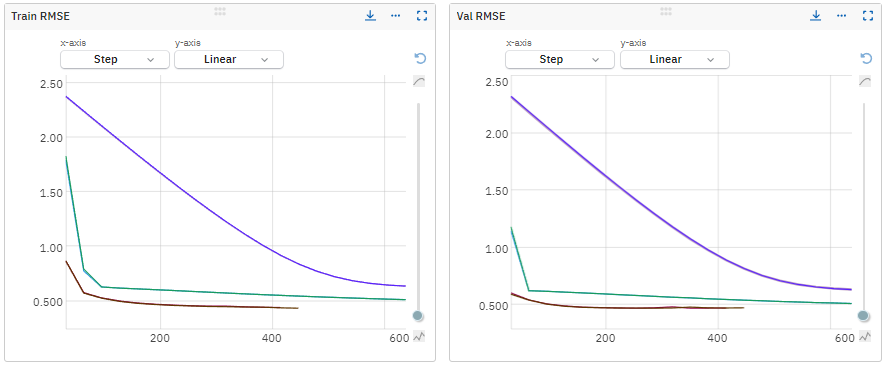

#### MAE comparsion

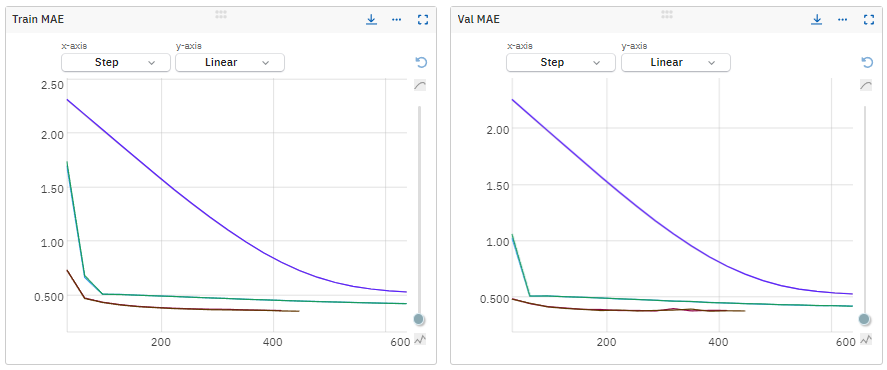

#### A learning rate of 0.01 yielded significantly improved RMSE and MSE results. Considering that both weight decay values, 0.01 and 0.1, produced similar outcomes with a learning rate of 0.01, and that both models began to overfit despite an improvement in training loss, I will now investigate these parameters alongside dropout values of 0.3 and 0.5.

In [ ]:
variable_model = 'LM'
dropout_list = [0.3, 0.5]
lr_list = [1e-2]
weight_decay_list = [0.01, 0.1]
params_list = get_params_list_lm(dropout_list, lr_list, weight_decay_list)
hyper_params_list = grid_search(params_list, small_train_df, small_val_df, small_test_df, variable_model, 256, 20)

In [74]:
print_grid_search(hyper_params_list)


Best hyperparameters: params:
{'dropout': 0.3}
{'lr': 0.01, 'weight_decay': 0.01},  validation loss: 0.468


Grid Search results:
params:
{'dropout': 0.3}
{'lr': 0.01, 'weight_decay': 0.01},  validation loss: 0.468

params:
{'dropout': 0.3}
{'lr': 0.01, 'weight_decay': 0.1},  validation loss: 0.469

params:
{'dropout': 0.5}
{'lr': 0.01, 'weight_decay': 0.01},  validation loss: 0.47

params:
{'dropout': 0.5}
{'lr': 0.01, 'weight_decay': 0.1},  validation loss: 0.472



### Runs 334-337

#### Loss comparsion (RMSE)

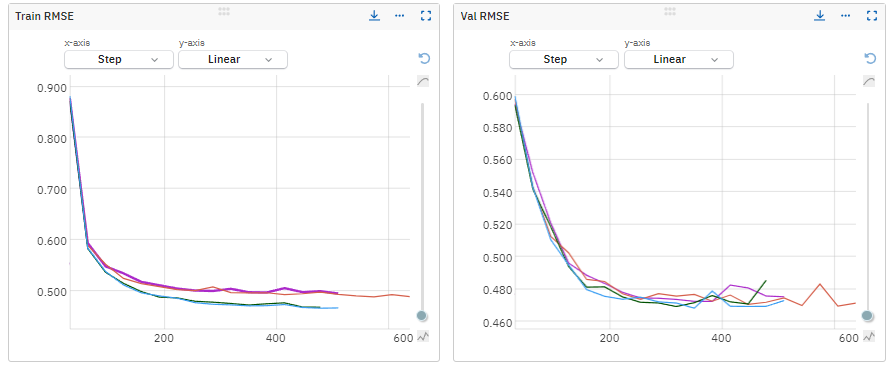

#### MAE comparsion

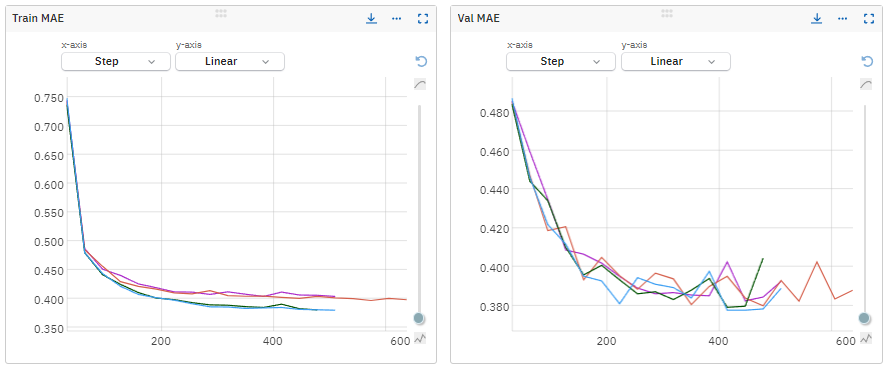

#### Chosen hyper-params:
#### {'dropout': 0.3}
#### {'lr': 0.01, 'weight_decay': 0.01},  validation loss: 0.468

In [ ]:
chosen_model, model_results, cp_path_new, total_time = test_model(
    model_name = "LM",
    cp_path = None,
    batch_size = 256,
    max_epochs = 25,
    train_df = train,
    val_df = test[:3000],
    test_df = test,
    model_hparams={"dropout": 0.3},
    optimizer_name = "Adam",
    optimizer_hparams = {"lr": 1e-2, "weight_decay": 0.01},
)
print(total_time/60)

### Run 341

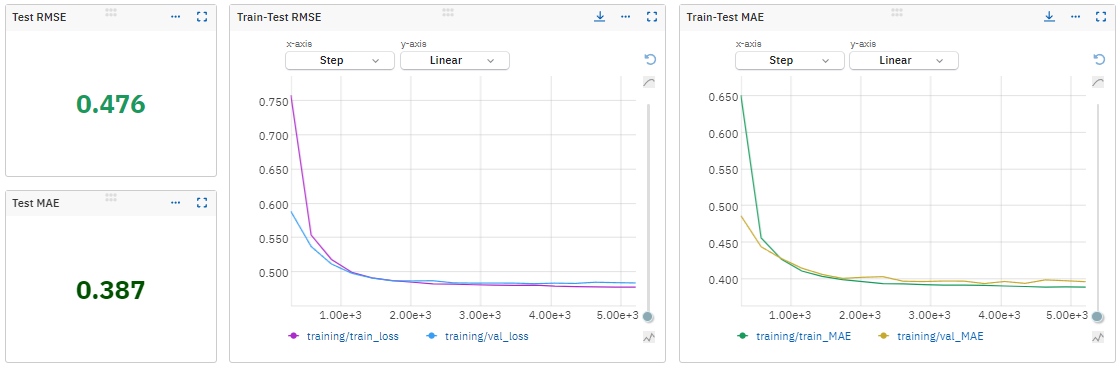

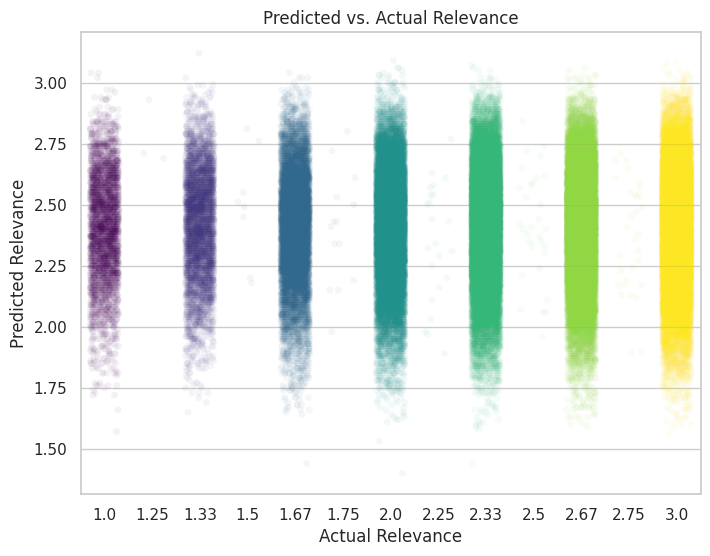

In [66]:
chosen_model.fc.to(device)
test.loc[:, 'predicted relevance'] = get_relevance(test, chosen_model, LMDataModule)
column_scatter_plot(test)

In [67]:
test[['relevance', 'predicted relevance']].describe()

,relevance,predicted relevance
count,112067.000000,112067.000000
mean,2.380525,2.405837
std,0.535274,0.223985
min,1.000000,1.400000
25%,2.000000,2.260000
50%,2.330000,2.420000
75%,3.000000,2.570000
max,3.000000,3.120000


### Explanation: 
#### Dropout proved effective in preventing overfitting, evidenced by the fact that the test loss yielded nearly identical RMSE and MAE results compared to the training set. The performance of the MPNet LM notably surpassed that of the XGBoost and LSTM character and word-level models, showcasing a significant improvement of 0.05 in RMSE and 0.04 in MAE. Additionally, the predicted values from the MPNet LM exhibited closer proximity to the true values, with the minimum and maximum values aligning more closely with the actual range of 1 to 3.

### Compare Results

In [70]:
# Initialize Neptune project
project = Project(
    project="odedreg/Assignment3",
    mode="read-only",
    api_token=""
)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/odedreg/Assignment3/


In [75]:
def highlight_best(value):
    """
    Apply background color to cells based on certain conditions.

    Parameters:
    - value: The value of the cell.

    Returns:
    - str: A string containing CSS for setting background color.
    """

    # Check if the value is the minimum Train MAE or Test MAE
    is_max_train_MAE = value == final_df['Train MAE'].min()
    is_max_test_MAE = value == final_df['Test MAE'].min()

    # Check if the value is the minimum Train Loss, Test Loss, or Running Time
    is_min_train_loss = value == final_df['Train Loss'].min()
    is_min_test_loss = value == final_df['Test Loss'].min()
    is_min_running_time = value == final_df['Running Time (Minutes)'].min()

    # Set background color based on conditions
    bg_color = ''
    if is_max_train_MAE or is_max_test_MAE:
        bg_color = '#008000'  # Dark green
    elif is_min_train_loss or is_min_test_loss or is_min_running_time:
        bg_color = '#008000'  # Dark green

    # Return CSS for background color
    return 'background-color: {}'.format(bg_color)


# Fetch runs table and filter specific runs
runs_table = project.fetch_runs_table().to_pandas()
specific_runs_df = runs_table[runs_table['sys/id'].isin(['AS-286', 'AS-322', 'AS-341'])]

# Reverse the rows in the df
specific_runs_df = specific_runs_df.iloc[::-1].reset_index(drop=True)

# Replace 'sys/id' values with 'CNN' and 'ResNet34'
specific_runs_df.loc[specific_runs_df['sys/id'] == 'AS-286', 'sys/id'] = 'Char-Level LSTM'
specific_runs_df.loc[specific_runs_df['sys/id'] == 'AS-322', 'sys/id'] = 'Word-Level LSTM'
specific_runs_df.loc[specific_runs_df['sys/id'] == 'AS-341', 'sys/id'] = 'MPNet LM'


# Select desired columns and rename them
specific_runs_df = specific_runs_df[['sys/id', 'training/train_loss' , 'training/test_loss', 'training/train_MAE', 'training/test_MAE','sys/running_time', 'training/epoch']]
specific_runs_df = specific_runs_df.rename(columns={
    'sys/id': 'Model Name',
    'training/train_loss': 'Train Loss',
    'training/test_loss': 'Test Loss',
    'training/train_MAE': 'Train MAE',
    'training/test_MAE': 'Test MAE',
    'training/epoch': 'Epochs',
    'sys/running_time': 'Running Time (Minutes)'
})

# Create a DataFrame to hold the XGBoost model's results
xgboost_df = pd.DataFrame({
    'Model Name': ['XGBoost'],
    'Train Loss': [0.529045],
    'Test Loss': [0.530754],
    'Train MAE': [0.43262],
    'Test MAE': [0.433707],
    'Running Time (Minutes)': [9.961358],
    'Epochs': [None],
})

# Concatenate the XGBoost DataFrame with specific_runs
final_df = pd.concat([xgboost_df, specific_runs_df], ignore_index=True)

final_df.reset_index(drop=True, inplace=True)
final_df['Running Time (Minutes)'] = final_df['Running Time (Minutes)'] / 60

# Get DataFrame values
final_df_values = final_df.values

# Apply style to relevant columns
final_df_style = pd.DataFrame(final_df_values, columns=final_df.columns).style.applymap(highlight_best, subset=['Train MAE', 'Test MAE', 'Train Loss', 'Test Loss', 'Running Time (Minutes)'])

final_df_style

Fetching table...: 0 [00:00, ?/s]

,Model Name,Train Loss,Test Loss,Train MAE,Test MAE,Running Time (Minutes),Epochs
0,XGBoost,0.529045,0.530754,0.432620,0.433707,0.166023,nan
1,Char-Level LSTM,0.467836,0.524106,0.379366,0.430399,2.990000,11.000000
2,Word-Level LSTM,0.386842,0.523920,0.304347,0.425743,4.142900,8.000000
3,MPNet LM,0.478165,0.475954,0.389226,0.386859,112.485950,18.000000
